In [ ]:
#pip install matplotlib geopandas cartopy

In [17]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import geopandas as gpd
import cartopy.crs as ccrs

In [6]:
combined_clean = pd.read_csv('combined_clean.csv')
combined_clean = combined_clean.dropna()

In [7]:
X = combined_clean[['Mean_Temp', 'Var_Temp', 'Extreme_Hot_Freq', 'Extreme_Cold_Freq', 'Mean_Range']]
y = combined_clean['CRI_Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [14]:
country_specific_mae = {}
for country in combined_clean['Country'].unique():
    country_clean = combined_clean[combined_clean['Country'] == country]
    X_country = country_clean[['Mean_Temp', 'Var_Temp', 'Extreme_Hot_Freq', 'Extreme_Cold_Freq', 'Mean_Range']]
    y_country = country_clean['CRI_Score'] 
    if len(X_country) > 0:
        y_pred_country = model.predict(X_country)
        mae_country = mean_absolute_error(y_country, y_pred_country)
        country_specific_mae[country] = mae_country
    else:
        country_specific_mae[country] = None

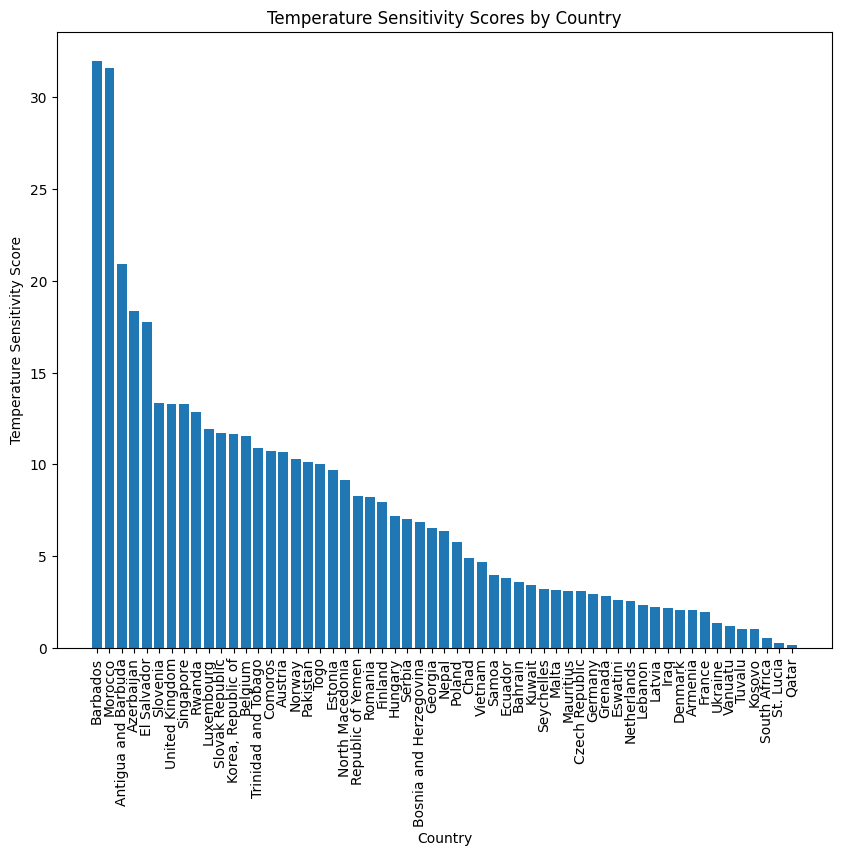

In [15]:
overall_mae = mean_absolute_error(y, model.predict(X))
sensitivity_scores = {country: abs(mae - overall_mae) for country, mae in country_specific_mae.items() if mae is not None}
ranked_countries = sorted(sensitivity_scores.items(), key=lambda x: x[1], reverse=True)
countries, scores = zip(*ranked_countries)
plt.figure(figsize=(10, 8))
plt.bar(countries, scores)
plt.xlabel('Country')
plt.ylabel('Temperature Sensitivity Score')
plt.title('Temperature Sensitivity Scores by Country')
plt.xticks(rotation=90)
#plt.savefig('tss.png')
plt.show()

In [18]:
countries = [item[0] for item in ranked_countries]
sensitivity_scores = [item[1] for item in ranked_countries]
sensitivity_scores_df = pd.DataFrame({
    'Country': countries,
    'Sensitivity_Score': sensitivity_scores
})
average_temperatures = combined_clean[['Country','Mean_Temp']].copy()

/var/folders/17/d28ssh495jd7ny97s0h1nsj00000gn/T/ipykernel_69770/241849440.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


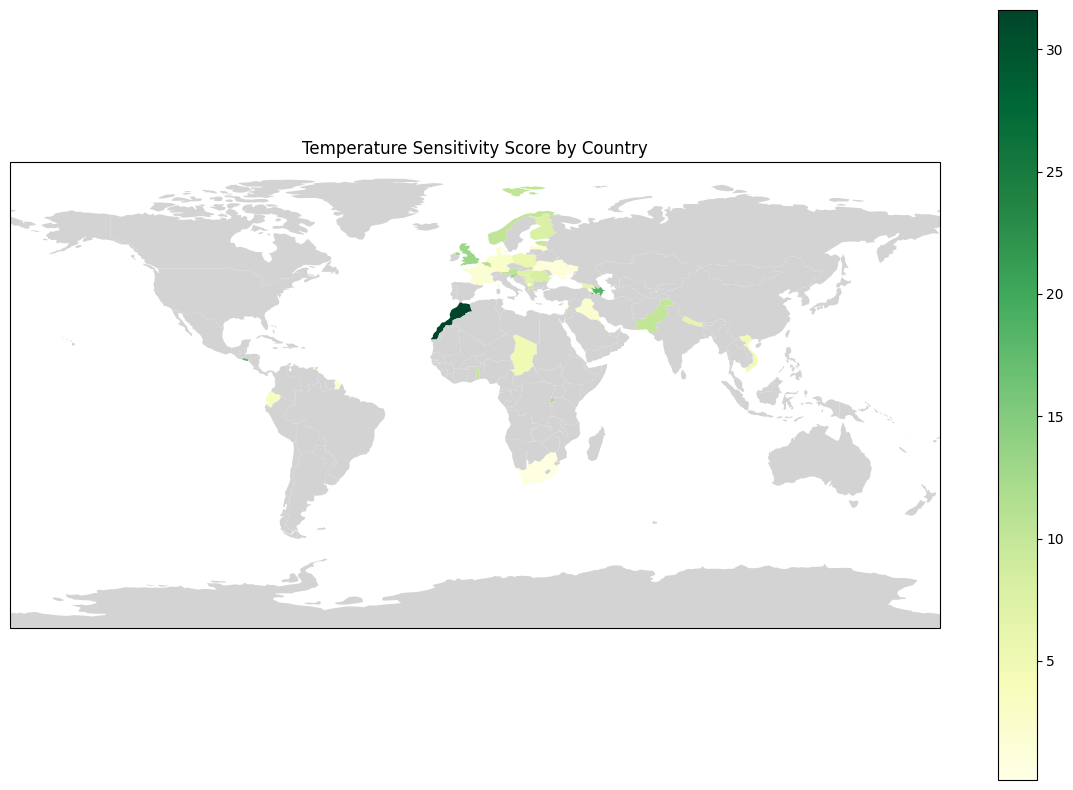

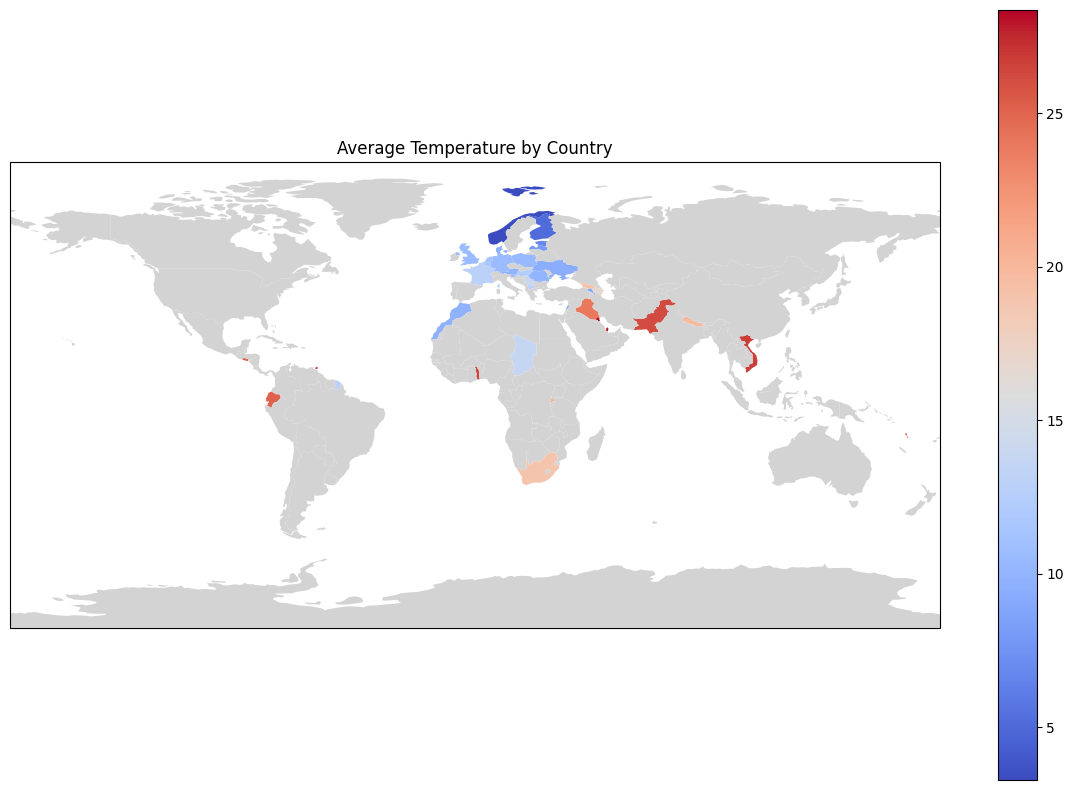

In [21]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

def plot_heatmap(df, value_col, title, cmap, save=None):
    # Merge the world geometry with the data
    merged = world.set_index('name').join(df.set_index('Country'))

    fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    merged.plot(column=value_col, ax=ax, legend=True, cmap=cmap, missing_kwds={"color": "lightgrey"})
    ax.set_title(title)
    # if save:
    #     plt.savefig(f'{save}.png')
    plt.show()

plot_heatmap(sensitivity_scores_df, 'Sensitivity_Score', 'Temperature Sensitivity Score by Country', 'YlGn',save='heatmap_tss')
plot_heatmap(average_temperatures, 'Mean_Temp', 'Average Temperature by Country', 'coolwarm',save='heatmap_tavg')